In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
from utils import rejeitar_hip_nula
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import GridSearchCV

from sklearn.discriminant_analysis import StandardScaler


from tqdm.notebook import tqdm

In [207]:
df = pd.read_csv("agaricus_lepiota_small_c.csv")

In [208]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,s,y,t,a,f,w,b,g,...,s,w,w,p,w,o,p,n,v,d
1,e,f,s,y,f,n,f,c,b,p,...,s,w,w,p,w,o,f,n,y,g
2,e,k,s,w,f,c,f,w,b,g,...,s,w,n,p,w,t,e,w,n,g
3,e,f,f,n,t,n,f,c,b,w,...,s,g,w,p,w,o,p,k,v,d
4,p,x,s,w,t,p,f,c,n,w,...,s,w,w,p,w,o,p,n,s,u


## Codificando o atributo de saída (class) para:
### e → 0, p → 1

In [209]:
df["class"] = df["class"].replace("p", "1")
df["class"] = df["class"].replace("e", "0")

In [210]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,x,s,y,t,a,f,w,b,g,...,s,w,w,p,w,o,p,n,v,d
1,0,f,s,y,f,n,f,c,b,p,...,s,w,w,p,w,o,f,n,y,g
2,0,k,s,w,f,c,f,w,b,g,...,s,w,n,p,w,t,e,w,n,g
3,0,f,f,n,t,n,f,c,b,w,...,s,g,w,p,w,o,p,k,v,d
4,1,x,s,w,t,p,f,c,n,w,...,s,w,w,p,w,o,p,n,s,u


<Axes: xlabel='stalk-root', ylabel='Count'>

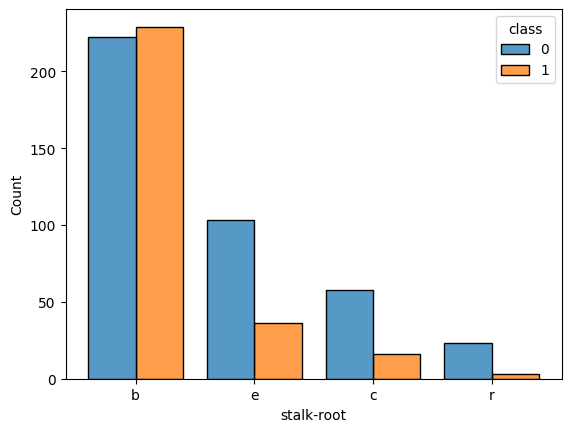

In [211]:
 sns.histplot(data=df, bins=10, x='stalk-root', hue='class', multiple='dodge', shrink=0.8)

## A coluna stalk-root tem atributos faltantes, porém que seus dados podem ser úteis visto que há uma variedade de amostras, então não decidimos excluir a coluna, e sim fazer a  exclusão das instâncias com valores faltantes.

In [212]:
df.isnull().sum().sum() #quantidade de dados faltantes

310

In [213]:
df.dropna(inplace=True)

y = df[['class']].values.ravel()
X = df.drop('class', axis=1)

df.isnull().sum().sum() #quantidade de dados faltantes após a imputação

0

## Codificação dos atributos categóricos

### Com a análise das caracteristicas, decidimos codificar as classes:
- ring-number (pode ser codificado por ser um valor ordinal, usaremos OrdinalEncoder)
- population (pode ser codificado por ser um valor ordinal, usaremos OneHotEncoder)
- stalk-shape (valor categórico significativo, pode ser codificado com OneHotEncoder)
- gill-size (valor categórico significativo, pode ser codificado com OneHotEncoder)


 ### Para aplicação do KNN, também faremos o OneHotEncoder nas demais classes.
### Feito a codificação, podemos perceber que fomos de 22 atributos para 107. 

In [214]:

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

colunas = ['ring-number', 'population', 'stalk-shape', 'gill-size']
demais_colunas = [c for c in X.columns if c not in colunas]
transformers = [
    ('oe_ring-number', OrdinalEncoder(categories=[['n', 'o', 't']]), ['ring-number']), 
    ('oh_population', OneHotEncoder(), ['population']), #vira 6 colunas
    ('oh_stalk-shape', OneHotEncoder(), ['stalk-shape']), #vira 2 colunas
    ('og_gill-size', OneHotEncoder(), ['gill-size']), #vira 2 colunas
    ('oh_demais_colunas', OneHotEncoder(), demais_colunas) 
]


ct = ColumnTransformer(transformers=transformers, remainder='passthrough')

X_ohoe = ct.fit_transform(X).todense()
colunas = ct.get_feature_names_out()

X_ohoe = pd.DataFrame(X_ohoe, columns=colunas)

X_ohoe.shape, X.shape




((690, 107), (690, 22))

### Classificador KNN e SVM em dois niveis ( 10 e 5 vias de validação cruzada)

In [215]:



k_niveis = [10,5]
n_neighbors = {'n_neighbors' : range(1,30, 2)}
svm_params = {'C': [1, 10, 100, 1000], 'gamma': ['auto', 'scale']}
acuracias_folds_knn = []
acuracias_folds_svm = []

skf = StratifiedKFold(n_splits=k_niveis[0], shuffle=True, random_state=1)

pgb = tqdm(total=20, desc='primeiro nivel (knn e svm)')

for treino_idx, teste_idx in skf.split(X_ohoe, y):
    X_treino_1 = X_ohoe.iloc[treino_idx]
    y_treino_1 = y[treino_idx]
    X_teste_1 = X_ohoe.iloc[teste_idx]
    y_teste_1 = y[teste_idx]

    ss = StandardScaler()
    X_treino_1 = ss.fit_transform(X_treino_1)
    X_teste_1 = ss.transform(X_teste_1)

    knn = KNeighborsClassifier()
    knn = GridSearchCV(knn, n_neighbors, cv=k_niveis[1], scoring='f1_macro')
    knn.fit(X_treino_1, y_treino_1)
    y_pred = knn.predict(X_teste_1)

    acuracias_folds_knn.append(f1_score(y_teste_1, y_pred, average='macro'))
    pgb.update(1)

    svc = SVC(kernel='rbf')
    svc = GridSearchCV(svc, svm_params, cv=k_niveis[1], scoring='f1_macro')
    svc.fit(X_treino_1, y_treino_1)
    y_pred = svc.predict(X_teste_1)

    acuracias_folds_svm.append(f1_score(y_teste_1, y_pred, average='macro'))
    pgb.update(1)

pgb.close()

print("------------ KNN ------------")
print("Acurácia média: ", np.mean(acuracias_folds_knn), "Acurácia desvio padrão: ", np.std(acuracias_folds_knn), "Acurácia mínima: ", np.min(acuracias_folds_knn), "Acurácia máxima: ", np.max(acuracias_folds_knn))


print("------------ SVM ------------")
print("Acurácia média: ", np.mean(acuracias_folds_svm), "Acurácia desvio padrão: ", np.std(acuracias_folds_svm), "Acurácia mínima: ", np.min(acuracias_folds_svm), "Acurácia máxima: ", np.max(acuracias_folds_svm))

    

primeiro nivel (knn e svm):   0%|          | 0/20 [00:00<?, ?it/s]

------------ KNN ------------
Acurácia média:  0.9557932694714253 Acurácia desvio padrão:  0.03272167505557572 Acurácia mínima:  0.8765652951699463 Acurácia máxima:  1.0
------------ SVM ------------
Acurácia média:  0.9360663684876286 Acurácia desvio padrão:  0.02582357024366689 Acurácia mínima:  0.905909090909091 Acurácia máxima:  0.9705128205128204


### Podemos observar que o KNN teve um desempenho melhor que o SVM, faremos o teste de hipótese para confirmar se há diferença significativa entre os dois classificadores.

In [217]:

### Teste de hipótese
print(rejeitar_hip_nula(acuracias_folds_knn, acuracias_folds_svm, 0.05))

(False, 0.15184187217491765)


### Conclusão
### Portanto, podemos concluir que não há diferença significativa entre os modelos KNN e SVM, visto que a acurácia de ambos é muito próxima, e o p-valor foi menor que 0.05.

Você usaria algum classificador que criou para decidir se comeria ou não um cogumelo classificado por
ele? Justifique usando o desempenho obtido e o resultado do teste de hipótese. Esta resposta deve estar
no final do caderno jupyter, após a análise estatística.

R: Sim, usaria o classificador KNN, pelo alto desempenho e por não haver diferença significativa entre os modelos KNN e SVM.